In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt

# load modules related to this exercise
import tools 
from model import model_class

import time # For timing speed

plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('axes', axisbelow=True)

In this file, we first plot the policy functions for the one dimensional model using finite differences and egm.
We then compare the speed/acurracy tradeoff for EGM and FD.

# Compute Policy Functions

This is for plotting the estimated policy functions from our models

In [16]:
# Setup model
model = model_class()
model.setup()
model.create_grids()

# Setup eta value
model.par.eta = 1.0
model.par.beta = 0.96

**Finite Difference**

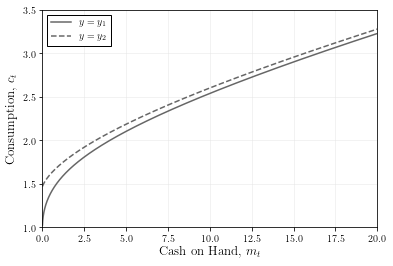

In [21]:
# Solve model
model.par.Nm = 10000
model.create_grids()
model.solve_fd()

# Generate figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Settings
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.set_xlim([0.0,20])
ax.set_ylim([1.0,3.5])
ax.set_xlabel(r'Cash on Hand, $m_t$', size=13)
ax.set_ylabel(r'Consumption, $c_t$', size=13)

# Plot
ax.plot(model.sol_fd.m[1:],model.sol_fd.c[0,1:], label= r'$y = y_1$', linestyle = '-', color = '0.4')
ax.plot(model.sol_fd.m[1:],model.sol_fd.c[1,1:], label= r'$y = y_2$', linestyle = '--', color = '0.4')

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False, loc = 2)
plt.savefig('figs/fd_1d_policy.pdf')

**Endogenous grid**

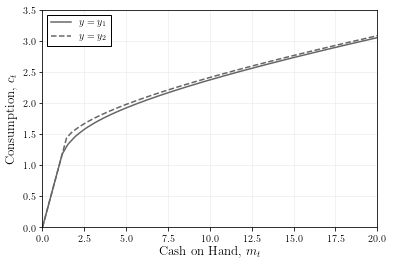

In [20]:
model.create_grids()
model.solve_egm()

# Generate figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Settings
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.set_xlim([0.0,20])
ax.set_ylim([.0,3.5])
ax.set_xlabel(r'Cash on Hand, $m_t$', size=13)
ax.set_ylabel(r'Consumption, $c_t$', size=13)

# Plot
ax.plot(model.sol_egm.m[0,:],model.sol_egm.c[0,:], label= r'$y = y_1$', linestyle = '-', color = '0.4')
ax.plot(model.sol_egm.m[1,:],model.sol_egm.c[1,:], label= r'$y = y_2$', linestyle = '--', color = '0.4')

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)
plt.savefig('figs/egm_1d_policy.pdf')

# Compare Computer Time

We here compare the time/error tradeoff for each of our solvers. This is achieved by first constructing the 'true' policy functions on a very fine grid. We then compute the approximated policy functions for smaller grid sizes, interpolate on the finer grid and compute the average error over $\#_\text{rep}$ replications.

### Generate the 'true' policy functions

Setup model

In [92]:
# Maximum grid points is 4000 right now
max_nr = 6000
m_max = 20

# Setup eta value
val = 1.0
model.par.eta = val

Run VFI

In [93]:
# Compute policy functions
model.par.Nm = max_nr # Set number
model.m_max = m_max

model.create_grids()
model.solve_vfi()
c_vfi_tr = model.sol_vfi.c

# Save fine asset grid for later interpolation
m_vfi_tr = model.par.grid_m

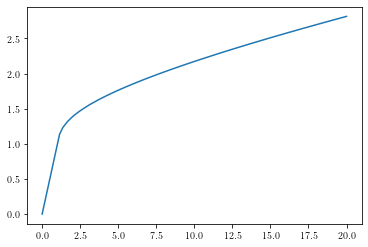

In [98]:
plt.plot(m_vfi_tr, c_vfi_tr[0,:])

Run EGM

In [65]:
# Compute policy functions
model.par.Na = max_nr-1 # Set number
model.m_max = m_max

model.create_grids()
model.solve_egm()
c_egm_tr = model.sol_egm.c

# Save fine asset grid for later interpolation
m_egm_tr = model.sol_egm.m

Run FD

In [42]:
# Compute policy functions
model.par.Nm = max_nr
model.par.m_max = m_max
model.create_grids()
model.solve_fd()
c_fd_tr = model.sol_fd.c[:,:]

# Save fine asset grid for later interpolation
m_fd_tr = model.sol_fd.m[:]

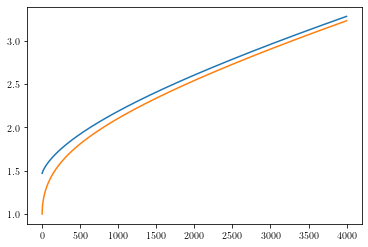

In [43]:
plt.plot(c_fd_tr[1])
plt.plot(c_fd_tr[0])

### Compute the errors

VFI

In [102]:
# 1. Points on the grid
num = 50
Nm_vec = np.linspace(10,1000,num)
n_reps = 10

# 2. Initialize
error_vfi = np.nan + np.zeros((n_reps,num))
time_vfi = np.nan + np.zeros((n_reps,num))

# 3. Run loop
for i,Na in enumerate(Nm_vec):
    for j in range(n_reps):
        
        # Setup model
        model = model_class()
        model.setup()
        val = 1.0
        model.par.eta = val
        model.par.Nm = int(Nm) # Set number of gridpoints
        model.create_grids()

        # Solve model and set time
        t0 = time.time()
        model.solve_vfi()
        t1 = time.time()

        time_vfi[j,i] = t1 - t0

        c_vfi = model.sol_vfi.c
        m_vfi = model.sol_vfi.m

        # Generate interpolated policy function
        c_vfi_interp_1 = tools.interp_linear_1d(m_vfi, c_vfi[0,:], m_vfi_tr)
        c_vfi_interp_2 = tools.interp_linear_1d(m_vfi, c_vfi[1,:], m_vfi_tr)
        c_vfi_interp = np.vstack((c_vfi_interp_1, c_vfi_interp_2))

        # Compute calculation error
        error_vfi[j,i] = 100 * 1/max_nr * 1/2 * np.sum(np.abs(c_vfi_interp - c_vfi_tr)/c_vfi_tr)
        

        print('Rep nr ' + str(j))
    
    print('Vec iteration is ' + str(i))
    
# 4. Compute average
time_vfi_av = np.nan + np.zeros(num)
error_vfi_av = np.nan + np.zeros(num)
    
time_vfi_av = np.sum(time_vfi, axis = 0) / n_reps
error_vfi_av = np.sum(error_vfi, axis = 0) / n_reps

Rep nr 0
Vec iteration is 0
Rep nr 0
Vec iteration is 1
Rep nr 0
Vec iteration is 2
Rep nr 0
Vec iteration is 3
Rep nr 0
Vec iteration is 4
Rep nr 0
Vec iteration is 5
Rep nr 0
Vec iteration is 6
Rep nr 0
Vec iteration is 7
Rep nr 0
Vec iteration is 8
Rep nr 0
Vec iteration is 9
Rep nr 0
Vec iteration is 10
Rep nr 0
Vec iteration is 11
Rep nr 0
Vec iteration is 12
Rep nr 0
Vec iteration is 13
Rep nr 0
Vec iteration is 14
Rep nr 0
Vec iteration is 15
Rep nr 0
Vec iteration is 16
Rep nr 0
Vec iteration is 17
Rep nr 0
Vec iteration is 18
Rep nr 0
Vec iteration is 19
Rep nr 0
Vec iteration is 20
Rep nr 0
Vec iteration is 21
Rep nr 0
Vec iteration is 22
Rep nr 0
Vec iteration is 23
Rep nr 0
Vec iteration is 24
Rep nr 0
Vec iteration is 25
Rep nr 0
Vec iteration is 26
Rep nr 0
Vec iteration is 27
Rep nr 0
Vec iteration is 28
Rep nr 0
Vec iteration is 29
Rep nr 0
Vec iteration is 30
Rep nr 0
Vec iteration is 31
Rep nr 0
Vec iteration is 32
Rep nr 0
Vec iteration is 33
Rep nr 0
Vec iteration i

In [79]:
# 1. Points on the grid
num = 50
Nm_vec = np.linspace(10,1000,num)
n_reps = 1

# 2. Initialize
error_egm = np.nan + np.zeros((n_reps,num))
time_egm = np.nan + np.zeros((n_reps,num))

# 3. Run loop
for i,Na in enumerate(Nm_vec):
    for j in range(n_reps):
        
        # Setup model
        model = model_class()
        model.setup()
        val = 1.0
        model.par.eta = val
        model.par.Na = int(Na) # Set number of gridpoints
        model.create_grids()

        # Solve model and set time
        t0 = time.time()
        model.solve_egm()
        t1 = time.time()

        time_egm[j,i] = t1 - t0

        c_egm = model.sol_egm.c
        m_egm = model.sol_egm.m

        # Generate interpolated policy function
        c_egm_interp_1 = tools.interp_linear_1d(m_egm[0,:], c_egm[0,:], m_egm_tr[0,:])
        c_egm_interp_2 = tools.interp_linear_1d(m_egm[1,:], c_egm[1,:], m_egm_tr[1,:])
        c_egm_interp = np.vstack((c_egm_interp_1, c_egm_interp_2))

        # Compute calculation error
        error_egm[j,i] = 100 * 1/max_nr * 1/2 * np.sum(np.abs(c_egm_interp - c_egm_tr)/c_egm_tr)
        
#         plt.plot(m_fd[1:], c_fd[0,1:])
#         plt.plot(m_fd[1:], c_fd[1,1:])
#         plt.show()
        
        print('Rep nr ' + str(j))
    
    print('Vec iteration is ' + str(i))

# 4. Compute average
time_egm_av = np.nan + np.zeros(num)
error_egm_av = np.nan + np.zeros(num)
    
time_egm_av = np.sum(time_egm, axis = 0) / n_reps
error_egm_av = np.sum(error_egm, axis = 0) / n_reps

Rep nr 0
Vec iteration is 0
Rep nr 0
Vec iteration is 1
Rep nr 0
Vec iteration is 2
Rep nr 0
Vec iteration is 3
Rep nr 0
Vec iteration is 4
Rep nr 0
Vec iteration is 5
Rep nr 0
Vec iteration is 6
Rep nr 0
Vec iteration is 7
Rep nr 0
Vec iteration is 8
Rep nr 0
Vec iteration is 9
Rep nr 0
Vec iteration is 10
Rep nr 0
Vec iteration is 11
Rep nr 0
Vec iteration is 12
Rep nr 0
Vec iteration is 13
Rep nr 0
Vec iteration is 14
Rep nr 0
Vec iteration is 15
Rep nr 0
Vec iteration is 16
Rep nr 0
Vec iteration is 17
Rep nr 0
Vec iteration is 18
Rep nr 0
Vec iteration is 19
Rep nr 0
Vec iteration is 20
Rep nr 0
Vec iteration is 21
Rep nr 0
Vec iteration is 22
Rep nr 0
Vec iteration is 23
Rep nr 0
Vec iteration is 24
Rep nr 0
Vec iteration is 25
Rep nr 0
Vec iteration is 26
Rep nr 0
Vec iteration is 27
Rep nr 0
Vec iteration is 28
Rep nr 0
Vec iteration is 29
Rep nr 0
Vec iteration is 30
Rep nr 0
Vec iteration is 31
Rep nr 0
Vec iteration is 32
Rep nr 0
Vec iteration is 33
Rep nr 0
Vec iteration i

FD

In [86]:
#### Points on the grid
num = 50
Nm_vec = np.linspace(10,4500,num)
n_reps = 10

# Initialize result vectors
error_fd = np.nan + np.zeros((n_reps,num))
time_fd = np.nan + np.zeros((n_reps,num))

for i,Nm in enumerate(Nm_vec):
    for j in range(n_reps):
        
        # Setup model
        model = model_class()
        model.setup()
        val = 1.0
        model.par.eta = val
        model.par.Nm = int(Nm) # Set number of gridpoints
        model.create_grids()

        # Solve model and set time
        t0 = time.time()
        model.solve_fd()
        t1 = time.time()

        time_fd[j,i] = t1 - t0

        c_fd = model.sol_fd.c[:,:]
        m_fd = model.sol_fd.m[:]

        # Generate interpolated policy function
        c_fd_interp_1 = tools.interp_linear_1d(m_fd, c_fd[0,:], m_fd_tr)
        c_fd_interp_2 = tools.interp_linear_1d(m_fd, c_fd[1,:], m_fd_tr)
        c_fd_interp = np.vstack((c_fd_interp_1, c_fd_interp_2))

        # Compute calculation error
        error_fd[j,i] = 100 * 1/max_nr * 1/2 * np.sum(np.abs(c_fd_interp - c_fd_tr)/c_fd_tr)
        
#         plt.plot(m_fd[1:], c_fd[0,1:])
#         plt.plot(m_fd[1:], c_fd[1,1:])
#         plt.show()
        
#         print('Rep nr ' + str(j))
    
#     print('Vec iteration is ' + str(i))

# Compute average
time_fd_av = np.nan + np.zeros(num)
error_fd_av = np.nan + np.zeros(num)
                                                                                                  
time_fd_av = np.sum(time_fd, axis = 0) / n_reps
error_fd_av = np.sum(error_fd, axis = 0) / n_reps

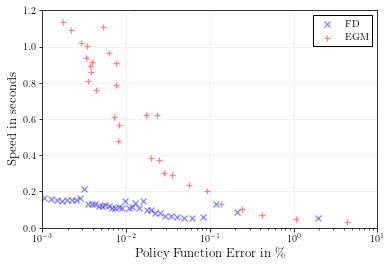

In [123]:
# Generate
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Settings
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
# ax.set_xlim([0.0,0.25])
ax.set_ylim([0,1.2])
ax.set_ylabel(r'Speed in seconds', size=13)
ax.set_xlabel(r'Policy Function Error in \%', size=13)

ax.set_xscale('log')
ax.set_xlim([1e-3,10])


# Plot
ax.scatter(error_fd_av,time_fd_av,marker='x', alpha = 0.5, edgecolor = 'k', linewidth=1.2, color = 'blue', label = 'FD')
ax.scatter(error_egm_av, time_egm_av, marker='+', alpha = 0.5, edgecolor = 'k', linewidth=1.2, color = 'red', label = 'EGM')

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)
plt.savefig('figs/tradeoff_1d.pdf')

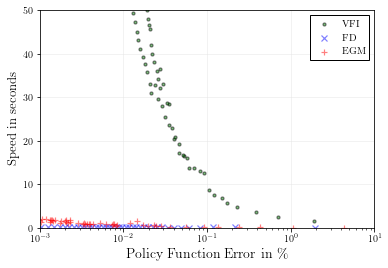

In [122]:
###### Generate
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Settings
ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.set_xlim([0.0,0.25])
ax.set_ylim([0,50])
ax.set_ylabel(r'Speed in seconds', size=13)
ax.set_xlabel(r'Policy Function Error in \%', size=14)

ax.set_xscale('log')
ax.set_xlim([1e-3,10])


# Plot
ax.scatter(error_vfi_av, time_vfi_av, marker='.', alpha = 0.5, edgecolor = 'k', linewidth=1.2, color = 'green', label = 'VFI')
ax.scatter(error_fd_av,time_fd_av, marker='x', alpha = 0.5, edgecolor = 'k', linewidth=1.2, color = 'blue', label = 'FD')
ax.scatter(error_egm_av, time_egm_av, marker='+', alpha = 0.5, edgecolor = 'k', linewidth=1.2, color = 'red', label = 'EGM')


ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)
plt.savefig('figs/tradeoff_1d_vfi.pdf')